Data: https://www.kaggle.com/datasets/jonwright13/ufo-sightings-around-the-world-better

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
import html

nltk.download('punkt')
nltk.download('stopwords')

pd.set_option('display.min_rows', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 500)

In [2]:
df = pd.read_csv('ufo-sightings.csv', index_col=[0])
df.head(3)

,Date_time,date_documented,Year,Month,Hour,Season,Country_Code,Country,Region,Locale,latitude,longitude,UFO_shape,length_of_encounter_seconds,Encounter_Duration,Description
0,1949-10-10 20:30:00,4/27/2004,1949,10,20,Autumn,USA,United States,Texas,San Marcos,29.883056,-97.941111,Cylinder,2700.0,45 minutes,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The Baptist Church sit
1,1949-10-10 21:00:00,12/16/2005,1949,10,21,Autumn,USA,United States,Texas,Bexar County,29.384210,-98.581082,Light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing across the sky &amp; making 90 degree turns on a dime.
2,1955-10-10 17:00:00,1/21/2008,1955,10,17,Autumn,GBR,United Kingdom,England,Chester,53.200000,-2.916667,Circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 England


In [3]:
# Create separate column for sighting date
df = df.rename(columns={"Date_time": "Sightings_datetime"}, errors="raise")
dates = pd.to_datetime(df['Sightings_datetime'])
df['Sightings_date'] = dates.dt.date

# Get the list of the columns from df.columns.tolist() and then rearrange
cols = ['Sightings_datetime',
'Sightings_date',
 'date_documented',
 'Year',
 'Month',
 'Hour',
 'Season',
 'Country_Code',
 'Country',
 'Region',
 'Locale',
 'latitude',
 'longitude',
 'UFO_shape',
 'length_of_encounter_seconds',
 'Encounter_Duration',
 'Description']

df = df[cols]

In [4]:
df['UFO_shape'].unique().tolist()

['Cylinder',
 'Light',
 'Circle',
 'Sphere',
 'Disk',
 'Fireball',
 'Unknown',
 'Oval',
 'Other',
 'Cigar',
 'Rectangle',
 'Chevron',
 'Triangle',
 'Formation',
 nan,
 'Delta',
 'Changing',
 'Egg',
 'Diamond',
 'Flash',
 'Teardrop',
 'Cone',
 'Cross',
 'Pyramid',
 'Round',
 'Crescent',
 'Flare',
 'Hexagon',
 'Dome',
 'Changed']

### Clean up the craft descriptions

In [5]:
# Combine the following:
    # Changed -> Changing: Changing
    # Chevron -> Cone -> Delta -> Diamond -> Pyramid -> Triangle: Triangular
    # Cylinder -> Cigar: Cylindrical
    # Dome -> Crescent: Dome
    # Oval -> Egg: Oval
    # Circle -> Round -> Sphere: Sphere
    # Unknown -> NULL: Other

df.fillna('Other', inplace=True)

def replace_values(df, replacements):
    for pattern, repl in replacements.items():
        df['UFO_shape'] = df['UFO_shape'].replace({pattern: repl}, regex=True)

replacements = {
    'Changed': 'Changing',
    'Chevron|Cone|Delta|Diamond|Pyramid|Triangle': 'Triangular',
    'Cylinder|Cigar': 'Cylindrical',
    'Crescent': 'Dome',
    'Egg': 'Oval',
    'Circle|Round': 'Sphere',
    'Unknown': 'Other'
}

replace_values(df, replacements)

In [6]:
# Check that it worked
df['UFO_shape'].unique().tolist()

['Cylindrical',
 'Light',
 'Sphere',
 'Disk',
 'Fireball',
 'Other',
 'Oval',
 'Rectangle',
 'Triangular',
 'Formation',
 'Changing',
 'Flash',
 'Teardrop',
 'Cross',
 'Dome',
 'Flare',
 'Hexagon']

### Replace length of encounter outliers with the average of non-outliers

In [7]:
# Convert seconds column to int
df = df.astype({"length_of_encounter_seconds": int})

# Replace anything with less than 1 second with 1
df.loc[df['length_of_encounter_seconds'] < 1, 'length_of_encounter_seconds'] = 1

# Calculate quartiles
Q1 = df['length_of_encounter_seconds'].quantile(0.25)
Q3 = df['length_of_encounter_seconds'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with the average of non-outliers
mask_outliers = (df['length_of_encounter_seconds'] < lower_bound) | (df['length_of_encounter_seconds'] > upper_bound)
avg_seconds = round(df[~mask_outliers]['length_of_encounter_seconds'].mean())

# Replace outliers
df.loc[mask_outliers, 'length_of_encounter_seconds'] = avg_seconds


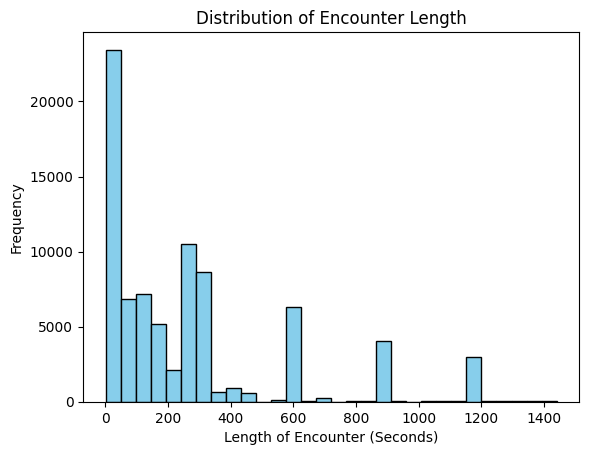

In [8]:
# Plot histogram
plt.hist(df['length_of_encounter_seconds'], bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Length of Encounter (Seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Encounter Length')

# Show plot
plt.show()


### Clean and tokenize encounter description

In [9]:
def preprocess_text(text):
    if isinstance(text, str):  
        text = html.unescape(text)  # Remove HTML entities
        tokens = word_tokenize(text)  # Tokenize the text
        return tokens
    else:
        return []  # Return an empty list for NaN values


df['Description_Tokenized'] = df['Description'].copy()
# Remove html symbols and tokenize
df['Description_Tokenized'] = df['Description_Tokenized'].apply(preprocess_text)

# Remove stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
r = ["...","’","''","``", "50ꯠ", "..", "'s", "'S"]
punctuation.update(r)
df['Description_Tokenized'] = df['Description_Tokenized'].apply(lambda x: [word for word in x if word.lower() not in stop_words and word.lower() not in punctuation])

# Save clean file without text columns
cleaneddf = df[df.columns[:-1]].copy()
cleaneddf.to_csv('ufo-sightings-cleaned.csv')


### Create a new file for a word cloud

In [ ]:
# Get a list of every available year and month
unique_year_month = df[['Year', 'Month']].drop_duplicates()
array_data = unique_year_month.to_numpy()
pairs_list = [list(pair) for pair in array_data]

# Top n words most used
N = 20

# Create a blank table to concat the results
blank_df = pd.DataFrame(columns=['Year', 'Month', 'Common_Words', 'Word_Count'])

for i in pairs_list:
    cloud_df = df[(df['Year'] == i[0]) & (df['Month'] == i[1])]
    
    cloud_df_all_words = [word for sublist in cloud_df['Description_Tokenized'] for word in sublist]
    cloud_df_word_freq = Counter(cloud_df_all_words)
    cloud_df_most_common_words = cloud_df_word_freq.most_common(N)

    maxN = len(cloud_df_most_common_words)

    # Apply logarithmic transformation to word counts. This step differentiates smaller changes in frequency more clearly
    max_freq = max([count for _, count in cloud_df_most_common_words])
    cloud_df_common_words_count = [1 + (10 * count / max_freq) for _, count in cloud_df_most_common_words]

    cloud_df_common_words = [word for word, _ in cloud_df_most_common_words]
    data = {'Year': [i[0]] * min(N, maxN), 'Month': [i[1]] * min(N, maxN), 'Common_Words': cloud_df_common_words, 'Word_Count': cloud_df_common_words_count}
    result = pd.DataFrame(data)

    blank_df = pd.concat([blank_df, result], ignore_index=True)

blank_df.to_csv('ufo-sightings-wordcloud.csv')

### Final dashboard result:
https://public.tableau.com/app/profile/igor.rodrigues/viz/UFOSightings-CraftTypeandDescriptions/CraftTypes